Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Thumthiti Pinto"
COLLABORATORS = ""

---

# Problem description

In the last assignment, we created fully connected neural networks to
solve the task of classifying whether a ship is present in a satellite photo.

This assignment will address the same task, but using Convolutional Neural Network layers.


## Goal:

In this notebook, you will need to create a model in `TensorFlow/Keras` *using Convolutional layers*  to classify satellite photos. 

- The features are images: 3 dimensional collection of pixels
  - 2 spatial dimensions
  - 1 dimension with 3 features for different parts of the color spectrum: Red, Green, Blue
- The labels are either 1 (ship is present) or 0 (ship is not present)

Unlike the model we created in the previous assignment (using Dense/Fully Connected layers)
we will retain *all three color channels* of the data rather than converting it to one channel gray scale.

There are two notebook files in this assignment:
- The one you are viewing now: First and only notebook you need to work on. 
    - Train your models here
    - There are cells that will save your models to a file
- **`Model_test.ipynb`**:
    - PLEASE IGNORE    


## Learning objectives
- Learn how to construct Neural Networks in a Keras Sequential model that uses Convolutional layer types.
- Appreciate how layer choices impact number of weights

# Import modules

In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline

## Import tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.3.1
Version 2, minor 3


# API for students

We have defined some utility routines in a file `helper.py`. There is a class named `Helper` in it.  

This will simplify problem solving

More importantly: it adds structure to your submission so that it may be easily graded

`helper = helper.Helper()`

- getData: Get a collection of labeled images, used as follows

  >`data, labels = helper.getData()`
- showData: Visualize labelled images, used as follows

  >`helper.showData(data, labels)`
- plot training results: Visualize training accuracy, loss and validation accuracy, loss

  >`helper.plotTrain(history, modelName)`, where history is the result of model training
- save model: save a model in `./models` directory

  >`helper.saveModel(model, modelName)`
- save history: save a model history in `./models` directory
  >`helper.saveHistory(history, modelName)`
 


In [2]:
# Load the helper module
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%reload_ext autoreload
%autoreload 1

# Import nn_helper module
import helper
%aimport helper

helper = helper.Helper()


# Get the data

The first step in our Recipe is Get the Data.

We have provided a utility method `getData` to simplify this for you

In [3]:
# Get the data
data, labels = helper.getData()
n_samples, width, height, channel = data.shape

print("Data shape: ", data.shape)
print("Labels shape: ", labels.shape)
print("Label values: ", np.unique(labels))



Data shape:  (4000, 80, 80, 3)
Labels shape:  (4000,)
Label values:  [0 1]


We will shuffle the examples before doing anything else.

This is usually a good idea
- Many datasets are naturally arranged in a *non-random* order, e.g., examples with the sample label grouped together
- You want to make sure that, when you split the examples into training and test examples, each split has a similar distribution of examples

In [4]:
# Shuffle the data
data, labels = sklearn.utils.shuffle(data, labels, random_state=42)

## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek


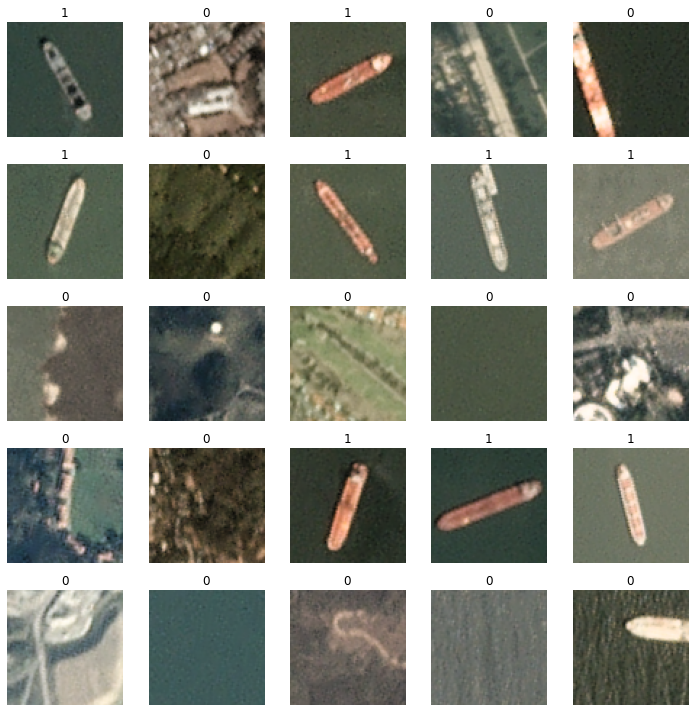

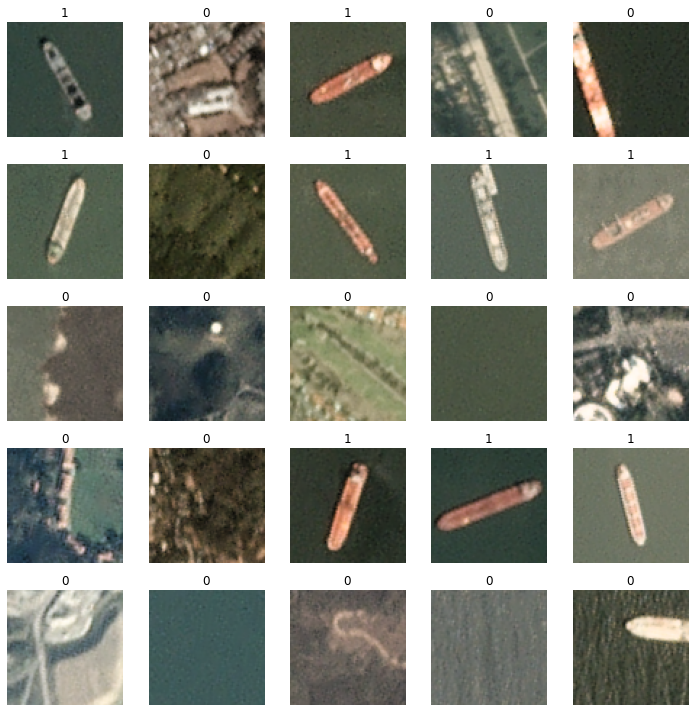

In [5]:
# Visualize the data samples
helper.showData(data[:25], labels[:25])


## Have  look at the data: Examine the image/label pairs

Rather than viewing the examples in random order, let's group them by label.

Perhaps we will learn something about the characteristics of images that contain ships.

We have loaded and shuffled our dataset, now we will take a look at image/label pairs. 

Feel free to explore the data using your own ideas and techniques.


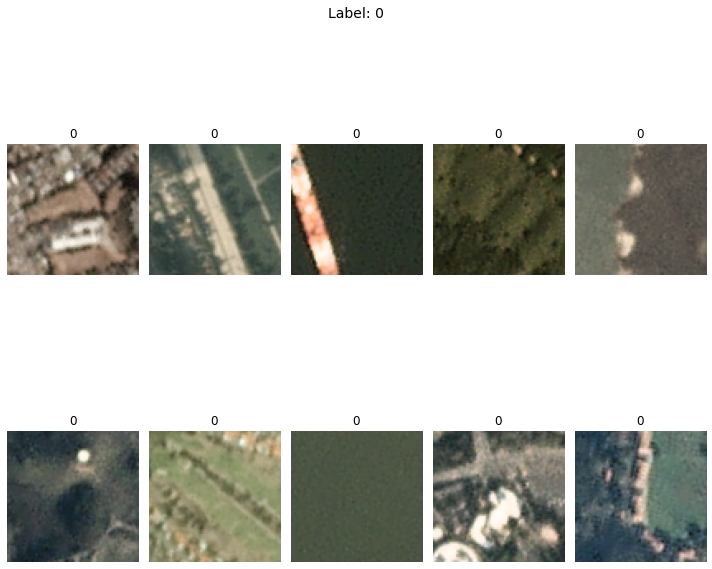

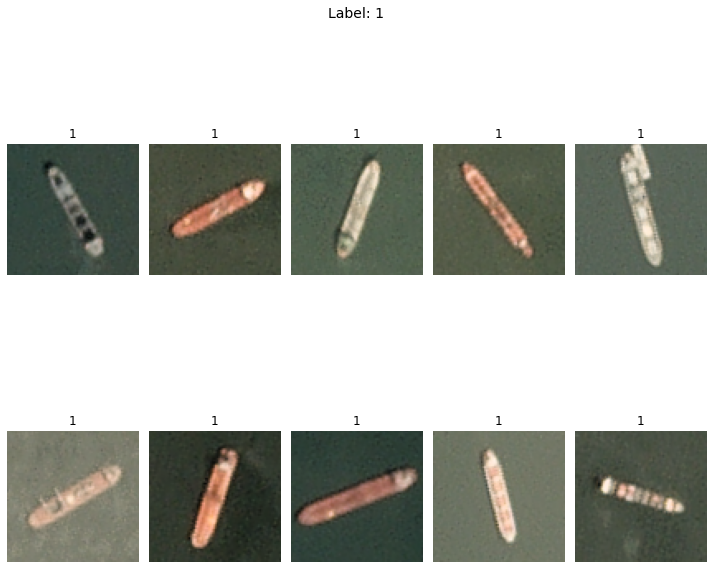

In [6]:
# Inspect some data (images)
num_each_label = 10

for lab in np.unique(labels):
    # Fetch images with different labels
    X_lab, y_lab = data[ labels == lab ], labels[ labels == lab]
    # Display images
    fig = helper.showData( X_lab[:num_each_label], [ str(label) for label in y_lab[:num_each_label] ], cmap="gray")
    _ = fig.suptitle("Label: "+  str(lab), fontsize=14)
    print("\n\n")


# Make sure the features are in the range [0,1]  

**Warm up exercise:** When we want to train on image data, the first thing we usually need to do is scaling. 

Since the feature values in our image data are between 0 and 255, to make them between 0 and 1, we need to divide them by 255.  

We also need to consider how to represent our target values
- If there are more than 2 possible target values, One Hot Encoding may be appropriate
    - **Hint**: Lookup `tf.keras.utils.to_categorical`
- If there are only 2 possible targets with values 0 and 1 we can use these targets without further encoding

**Question**
- Set variable `X` to be our gray-scale examples (`data_bw`), but with values in the range [0,1]
- Set variable `y` to be the representation of our target values



##### Since there are shape 1,4000,80,80,3 We will reshape into 4000,80,80,3

In [7]:
# Scale the data
# Assign values for X, y
#  X: the array of features
#  y: the array of labels
# The length of X and y should be identical and equal to the length of data.

from tensorflow.keras.utils import to_categorical
X, y = np.array([data/255]).reshape(4000,80,80,3) , np.array([labels]).reshape(4000,1)



In [8]:
# Check if your solution is right 

assert X.shape == (4000, 80, 80, 3)
assert ( (y.shape == (4000,)) or (y.shape == (4000,1)) )


# Split data into training data and testing data
To train and evaluate a model, we need to split the original dataset into
a training subset (in-sample) and a test subset (out of sample).

We will do this for you in the cell below.

**DO NOT** shuffle the data until after we have performed the split into train/test sets
- We want everyone to have the **identical** test set for grading
- Do not change this cell



In [9]:
# Split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Save X_train, X_test, y_train, y_test for final testing
if not os.path.exists('./data'):
    os.mkdir('./data')
np.savez_compressed('./data/train_test_data.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)


# Create a simple CNN model 

**Question:** Create a Keras Sequential model:
- With a single Convolutional Layer providing the number of features given in variable `num_conv_features1` indicated below.
    - You may choose your own kernel size
    - Use full padding
- Feeding a head layer implementing Classification  

Please name your Convolutional layer "CNN_1" and your Dense layer (head layer) "dense_head"

Set variable `model0` to be a Keras `Sequential` model object that implements your model.

**Hints:**
1. The `input shape` argument of the first layer should be the shape of a single example, which should be 3-dimensional. We don't need to flatten the data before feeding the Convolutional layer.
2. What is the shape of the output of the Convolutional Layer ? What should be the shape of the input to the Classification head ?
    - You may want to flatten the output of the Convolutional layer before feeding the Classification head.
3. The number of units in your head layer 
    - Depends on how you represented the target
    - It should be equal to the final dimension of  `y`

4. Activation function for the head layer: Since this is a classification problem
    - Use  `sigmoid` if your target's final dimension equals 1
    - Use  `softmax` if your target's final dimension is greater than 1

Think about the number of parameters in this model and whether
it is likely to be prone to overfitting. 
If you feel the need:

- A Dropout layer maybe helpful to prevent overfitting and accelerate your training process. 
    - If you want to use a Dropout layer, you can use `Dropout()`, which is in  `tensorflow.keras.layers`. 



In [16]:
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Functional API
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [1]:
y.shape

NameError: name 'y' is not defined

In [18]:
X.shape

(4000, 80, 80, 3)

In [20]:
# Set model0 equal to a Keras Sequential model
model0 = None

num_conv_features1 = 32
num_classes = 1 

model0 = None
model0 = Sequential()
model0.add(Conv2D(num_conv_features1 , kernel_size = (4,4), activation = 'relu', padding = "same" , input_shape = (80,80,3) , name = "CNN_1"))
model0.add(Flatten())
model0.add(Dense(num_conv_features1*2, activation = 'relu'))
model0.add(Dropout(0.5))
model0.add(Dense(num_classes , activation = "sigmoid", name = "dense_head"))

model0.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        1568      
_________________________________________________________________
flatten_3 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                13107264  
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_head (Dense)           (None, 1)                 65        
Total params: 13,108,897
Trainable params: 13,108,897
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Plot your model
plot_model(model0)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## Train model


**Question:**

Now that you have built your first model, you will compile and train it. The requirements are as follows:

- Split the **training** examples `X_train, y_train` again !
    - 80% will be used for training the model
    - 20% will be used as validation (out of sample) examples
    - Use `train_test_split()` from `sklearn` to perform this split
        -  Set the `random_state` parameter of `train_test_split()` to be 42

- Loss function: 
    - `binary_crossentropy` if your target is one-dimensional
    - `categorical_crossentropy`if your target is One Hot Encoded
- Metric: "accuracy"
- Use the value in variable `max_epochs` as the number of epochs for training

- Plot your training results using the`plotTrain` method described in the Student API above.


### we will split the data further from training dataset into 
    - X_train_2 , y_train_2 is the training dataset
    - X_val , y_val is for validation set

In [22]:
model_name0 = "CNN + Head"

from sklearn.model_selection import train_test_split
X_train_2, X_val2, y_train_2, y_val2 = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

loss = "binary_crossentropy"
metrics = [ "accuracy" ]
model0.compile(optimizer='adam',
                    loss=loss,
                    metrics=metrics)


max_epochs = 10

history0 = model0.fit(X_train_2,y_train_2, epochs=max_epochs,  validation_data=(X_val2, y_val2), shuffle=True)
# YOUR CODE HERE
# raise NotImplementedError()



Epoch 1/10
90/90 [==============================] - 1s 12ms/step - loss: 0.7043 - accuracy: 0.8330 - val_loss: 0.2332 - val_accuracy: 0.9000
Epoch 2/10
90/90 [==============================] - 1s 8ms/step - loss: 0.2271 - accuracy: 0.9181 - val_loss: 0.1757 - val_accuracy: 0.9389
Epoch 3/10
90/90 [==============================] - 1s 8ms/step - loss: 0.1826 - accuracy: 0.9323 - val_loss: 0.1214 - val_accuracy: 0.9514
Epoch 4/10
90/90 [==============================] - 1s 9ms/step - loss: 0.1536 - accuracy: 0.9451 - val_loss: 0.1240 - val_accuracy: 0.9514
Epoch 5/10
90/90 [==============================] - 1s 9ms/step - loss: 0.1132 - accuracy: 0.9628 - val_loss: 0.1098 - val_accuracy: 0.9542
Epoch 6/10
90/90 [==============================] - 1s 9ms/step - loss: 0.1107 - accuracy: 0.9622 - val_loss: 0.1034 - val_accuracy: 0.9639
Epoch 7/10
90/90 [==============================] - 1s 9ms/step - loss: 0.1092 - accuracy: 0.9649 - val_loss: 0.0911 - val_accuracy: 0.9597
Epoch 8/10
90/90 [=

### We get the validation accuracy :0.9764 for 1st model 

## How many weights in the model ?

**Question:** 

Calculate the number of parameters in your model.  

Set variable `num_parameters0` to be equal to the number of parameters in your model.

**Hint:** The model object may have a method to help you ! Remember that Jupyter can help you find the methods that an object implements.



In [21]:
# Set num_parameters2 equal to the number of weights in the model
num_parameters0 = None

# YOUR CODE HERE
# raise NotImplementedError()
num_parameters0 = model0.count_params()
num_parameters0

print("Parameters number in model0: ", num_parameters0)

13108897

Parameters number in model0:  13108897


### The weight of the model contains 13,108,897 parameter which are so much bigger than the training set 
    * This might lead to high overfitting problem
    * Dropout layer are needed 
    * Maxpooling are also needed

## Evaluate the model

**Question:**

We have trained our model. We now need to  evaluate the model using the test dataset created in an earlier cell.

Please store the model score in a variable named `score0`.   

**Hint:** The model object has a method  `evaluate`.  Use that to compute the score.




In [22]:
score0 = []

# YOUR CODE HERE
# raise NotImplementedError()

score0 = model0.evaluate(X_test, y_test,verbose=0)


print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name0, l=score0[0], a=score0[1]))

CNN + Head: Test loss: 0.07 / Test accuracy: 0.97


Your test accuracy should be around 0.9

In [68]:
from sklearn.metrics import classification_report
print(classification_report(y_test , np.where(model0.predict(X_test) > 0.5 , 1 , 0)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       313
           1       0.93      0.94      0.94        87

    accuracy                           0.97       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.97      0.97      0.97       400



#### This is the performance of previous assignment (assignment 3 best model)

               precision    recall  f1-score   support

            0       0.96      0.98      0.97       313
            1       0.91      0.84      0.87        87

     accuracy                           0.95       400
    macro avg       0.93      0.91      0.92       400
    weight avg      0.95      0.95      0.95       400

## The 1st model using simple cnn already perform better than past assignment we have done
    * We will try to make it better in model1 - model 9

## Save the trained model0 and history for submission

Your fitted model can be saved for later use
- In general: so you can resume training at a later time
- In particular: to allow us to grade it !

Execute the following cell to save your model, which you will submit to us for grading.

In [23]:
helper.saveModel(model0, model_name0)
helper.saveHistory(history0, model_name0)

Directory .\models\CNN + Head already exists, files will be over-written.
Model saved in directory .\models\CNN + Head; create an archive of this directory and submit with your assignment.
Directory .\models\CNN + Head already exists, files will be over-written.


In [24]:
## Restore the model (make sure that it works)
model_loaded = helper.loadModel(model_name0)
score_loaded = model_loaded.evaluate(X_test, y_test, verbose=0)

assert score_loaded[0] == score0[0] and score_loaded[1] == score0[1]

# Create a model with 4 Convolutional layers

**Question:** 

We will now create a model with more Convolutional layers.
- Use **4** Convolutional layers.
    - You may choose your own kernel size
    - Use full padding
    - ReLU activation functions for the Convolutional layers

    - Each of the first two Convolutional layers should have the number of features given in variable `num_conv_features1` indicated below
        - Please name thee layers "CNN_1" and "CNN_2"
    - Each of the last two Convolutional layers should have the number of features given in variable `num_conv_features2` indicated below
        - Please name thee layers "CNN_3" and "CNN_4"
- Insert a `MaxPooling` layer after every two Convolutional layers (e.g., after CNN_2 and CNN_4)
    - to reduce each spatial dimension by a factor of 2  

- Please name your head layer "dense_head". 

Set variable `model1` to be a Keras `Sequential` model object that implements your model.

**Hints:**
- Don't forget to flatten the output of the layer feeding the Classification head 
- A Dropout layer maybe helpful to prevent overfitting and accelerate your training process. 


### The new model will also include dropout layer 
    * dropout layer (0.5) before final dense layer 
    * the number of node in dense layer = 64*2 = 128


In [28]:
# Set model1 equal to a Keras Sequential model

model1 = None
num_conv_features1 = 32
num_conv_features2 = 64


model1 = Sequential()
model1.add(Conv2D(num_conv_features1 , kernel_size = (4,4), activation = 'relu', padding = "same" , input_shape = (80,80,3) , name = "CNN_1"))
model1.add(Conv2D(num_conv_features1 , kernel_size = (4,4), activation = 'relu', padding = "same" ,  name = "CNN_2"))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(num_conv_features2 , kernel_size = (4,4), activation = 'relu', padding = "same"  , name = "CNN_3"))
model1.add(Conv2D(num_conv_features2 , kernel_size = (4,4), activation = 'relu', padding = "same" ,  name = "CNN_4"))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dense(num_conv_features2*2, activation = 'relu'))
model1.add(Dropout(0.5))
model1.add(Dense(num_classes , activation = "sigmoid", name = "dense_head"))

model1.summary()


# model1.add(Dropout(0.5))

# YOUR CODE HERE
# raise NotImplementedError()



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        1568      
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 32)        16416     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 64)        32832     
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 64)        65600     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 25600)            

In [29]:
# Plot your model
plot_model(model1)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## Train model

**Question:**

Train your new model following the same instructions as given for training the first model.
- Use the same datasets for training and validation as in your first model
- Use the same Loss function and metrics as in your first model
- **Except**: Save your training results in a variable named `history1`



In [30]:
# Train the model using the API
model_name1 = "4CNNs + Head"



loss = "binary_crossentropy"
metrics = [ "accuracy" ]
model1.compile(optimizer='adam',
                    loss=loss,
                    metrics=metrics)


max_epochs = 10

history1 = model1.fit(X_train_2,y_train_2, epochs=max_epochs,  validation_data=(X_val2, y_val2), shuffle=True)


# YOUR CODE HERE
# raise NotImplementedError()

Epoch 1/10
90/90 [==============================] - 49s 542ms/step - loss: 0.3957 - accuracy: 0.8427 - val_loss: 0.3043 - val_accuracy: 0.8667
Epoch 2/10
90/90 [==============================] - 45s 496ms/step - loss: 0.2594 - accuracy: 0.8944 - val_loss: 0.1885 - val_accuracy: 0.9236
Epoch 3/10
90/90 [==============================] - 47s 526ms/step - loss: 0.1973 - accuracy: 0.9163 - val_loss: 0.1201 - val_accuracy: 0.9556
Epoch 4/10
90/90 [==============================] - 44s 494ms/step - loss: 0.1489 - accuracy: 0.9427 - val_loss: 0.0787 - val_accuracy: 0.9694
Epoch 5/10
90/90 [==============================] - 45s 498ms/step - loss: 0.1145 - accuracy: 0.9611 - val_loss: 0.0730 - val_accuracy: 0.9722
Epoch 6/10
90/90 [==============================] - 46s 515ms/step - loss: 0.0830 - accuracy: 0.9694 - val_loss: 0.0718 - val_accuracy: 0.9764
Epoch 7/10
90/90 [==============================] - 47s 522ms/step - loss: 0.0683 - accuracy: 0.9764 - val_loss: 0.0482 - val_accuracy: 0.9819

### We get val_accuracy: 0.9875 : very high

## How many weights in this model ?

**Question:** Calculate the number of parameters in your new model.  

Set variable `num_parameters1` to be equal to the number of parameters in your model.



In [31]:
# Set num_parameters3 equal to the number of weights in the model
num_parameters1 = None

# YOUR CODE HERE
# raise NotImplementedError()

num_parameters1 = model1.count_params()


print('Parameters number in model1:', num_parameters1)

Parameters number in model1: 3393473


* Our new model is just 3,393,473 parameter 
* Which contain 10 million lower number of parameter
* This are good method for preventing overfit for the deeplearning model

## Evaluate the model

Evaluate your new model following the same instructions as given for evaluating the first model.
- **Except**: store the model score in a variable named `score1`.  



In [32]:
score1 = []

# YOUR CODE HERE
# raise NotImplementedError()
score1 = model1.evaluate(X_test, y_test,verbose=0)



print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name1, l=score1[0], a=score1[1]))

4CNNs + Head: Test loss: 0.04 / Test accuracy: 0.99


Is your test accuracy higher than before ?

### Yes, our new model (model1 with 4 conv layer achive better accuracy)
    which is the highest accuracy that we have ever get along 3 assignment with the same data

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test , np.where(model1.predict(X_test) > 0.5 , 1 , 0)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       313
           1       0.96      0.99      0.97        87

    accuracy                           0.99       400
   macro avg       0.98      0.99      0.98       400
weighted avg       0.99      0.99      0.99       400



In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test , np.where(model1.predict(X_test) > 0.5 , 1 , 0))

array([[309,   4],
       [  1,  86]], dtype=int64)

## Right now , the model1 is better than model0 
    * We almost reach perfect accuracy 
    * Using much less paramter in the model
    * We only miss 5 data point
    * This is best model that we have created so far

# Save your trained model1 and history1

In [76]:
helper.saveModel(model1, model_name1)
helper.saveHistory(history1, model_name1)

Directory .\models\4CNNs + Head already exists, files will be over-written.
Model saved in directory .\models\4CNNs + Head; create an archive of this directory and submit with your assignment.
Directory .\models\4CNNs + Head already exists, files will be over-written.


## Discussion


You can learn a lot by experimenting.  Some ideas to try:
- Change the kernel size in Convolutional layers
- Change the number of features of Convolutional layers
- Experiment with different pooling layers: `MaxPooling2D` and `AveragePooling2D`
- Change the activation function

Observe the effect of each change on the Loss and Accuracy.

Questions to consider:
- How did the number of parameters change between the two models ?
- How did the choice of layer types affect the number of parameters ?


## CAN we achieve perfect accuracy?  

* In the first part we have explored the model 
* The model wre much better than the original 2 assignment model we have created before 
* We only get 5 data that are miss classified 
* Now (Just for fun we will try to achieve PERFECT ACCURACY)
* I cannot garuntee the prefect accuracy after this task performed, but we will  try 
* Note that I cannot do the tuning normally
    * Since in the windowed system I need to setup environment before using tensorflow on gpu
    * the below deeplearning we all be done by CPU (much slower)
    * So I will do the little tuning by changing each parameter individually 
    * Can came up with final model model9 : whether is is the best model to achieve perfect or not

### We will create the model with the same old parameter as the model1

    model2 : increase kernel size
    model3 : reduce kernel size
    model4 : increase number of features in conv (number of feature *2)
    model5 : reduce number of feature in conv (number of feature /2)
    model6 : use average pooling after first 2 conv
    model7 : all change activation function to sigmoid (this one is very good for assginement 3) 
    model8 : add additional 2 Conv layer
    model9 : use the parameter of best of everymodel 

### model 2 increase kernel size

In [42]:
# same parameter as model1
# only change kernel size to 5,5

model2 = None
num_conv_features1 = 32
num_conv_features2 = 64


model2 = Sequential()
model2.add(Conv2D(num_conv_features1 , kernel_size = (5,5), activation = 'relu', padding = "same" , input_shape = (80,80,3) , name = "CNN_1"))
model2.add(Conv2D(num_conv_features1 , kernel_size = (5,5), activation = 'relu', padding = "same" ,  name = "CNN_2"))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(num_conv_features2 , kernel_size = (5,5), activation = 'relu', padding = "same"  , name = "CNN_3"))
model2.add(Conv2D(num_conv_features2 , kernel_size = (5,5), activation = 'relu', padding = "same" ,  name = "CNN_4"))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(num_conv_features2*2, activation = 'relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes , activation = "sigmoid", name = "dense_head"))

model2.summary()



Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        2432      
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 32)        25632     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 64)        51264     
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 64)        102464    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 25600)            

In [43]:
model_name2 = "experimental_cnn2"

loss = "binary_crossentropy"
metrics = [ "accuracy" ]
model2.compile(optimizer='adam',
                    loss=loss,
                    metrics=metrics)

max_epochs = 10

history2 = model2.fit(X_train_2,y_train_2, epochs=max_epochs,  validation_data=(X_val2, y_val2), shuffle=True)


Epoch 1/10
90/90 [==============================] - 64s 707ms/step - loss: 0.3889 - accuracy: 0.8469 - val_loss: 0.1879 - val_accuracy: 0.9194
Epoch 2/10
90/90 [==============================] - 62s 694ms/step - loss: 0.2495 - accuracy: 0.9007 - val_loss: 0.1574 - val_accuracy: 0.9292
Epoch 3/10
90/90 [==============================] - 64s 710ms/step - loss: 0.1746 - accuracy: 0.9295 - val_loss: 0.1167 - val_accuracy: 0.9500
Epoch 4/10
90/90 [==============================] - 63s 699ms/step - loss: 0.1300 - accuracy: 0.9451 - val_loss: 0.0751 - val_accuracy: 0.9681
Epoch 5/10
90/90 [==============================] - 60s 665ms/step - loss: 0.0996 - accuracy: 0.9618 - val_loss: 0.0566 - val_accuracy: 0.9806
Epoch 6/10
90/90 [==============================] - 62s 690ms/step - loss: 0.0716 - accuracy: 0.9743 - val_loss: 0.0507 - val_accuracy: 0.9833
Epoch 7/10
90/90 [==============================] - 63s 695ms/step - loss: 0.0568 - accuracy: 0.9774 - val_loss: 0.0394 - val_accuracy: 0.9833

In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_test , np.where(model2.predict(X_test) > 0.5 , 1 , 0)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       313
           1       0.91      0.99      0.95        87

    accuracy                           0.98       400
   macro avg       0.96      0.98      0.97       400
weighted avg       0.98      0.98      0.98       400



#### Overall model 2 are not better than model 1
    * In the local tuning using kernel size 4,4 are btter

### model 3 reduce kernel size

In [45]:
# same parameter as model1 and model 2
# only change kernel size to 3,3

model3 = None
num_conv_features1 = 32
num_conv_features2 = 64


model3 = Sequential()
model3.add(Conv2D(num_conv_features1 , kernel_size = (3,3), activation = 'relu', padding = "same" , input_shape = (80,80,3) , name = "CNN_1"))
model3.add(Conv2D(num_conv_features1 , kernel_size = (3,3), activation = 'relu', padding = "same" ,  name = "CNN_2"))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(num_conv_features2 , kernel_size = (3,3), activation = 'relu', padding = "same"  , name = "CNN_3"))
model3.add(Conv2D(num_conv_features2 , kernel_size = (3,3), activation = 'relu', padding = "same" ,  name = "CNN_4"))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Flatten())
model3.add(Dense(num_conv_features2*2, activation = 'relu'))
model3.add(Dropout(0.5))
model3.add(Dense(num_classes , activation = "sigmoid", name = "dense_head"))

model3.summary()



Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        896       
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 64)        18496     
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 25600)            

In [46]:
model_name3 = "experimental_cnn3"

loss = "binary_crossentropy"
metrics = [ "accuracy" ]
model3.compile(optimizer='adam',
                    loss=loss,
                    metrics=metrics)

max_epochs = 10
history3 = model3.fit(X_train_2,y_train_2, epochs=max_epochs,  validation_data=(X_val2, y_val2), shuffle=True)


Epoch 1/10
90/90 [==============================] - 28s 307ms/step - loss: 0.3533 - accuracy: 0.8556 - val_loss: 0.1563 - val_accuracy: 0.9389
Epoch 2/10
90/90 [==============================] - 28s 306ms/step - loss: 0.1886 - accuracy: 0.9243 - val_loss: 0.1201 - val_accuracy: 0.9611
Epoch 3/10
90/90 [==============================] - 28s 308ms/step - loss: 0.1546 - accuracy: 0.9441 - val_loss: 0.0938 - val_accuracy: 0.9667
Epoch 4/10
90/90 [==============================] - 28s 308ms/step - loss: 0.1160 - accuracy: 0.9549 - val_loss: 0.0857 - val_accuracy: 0.9681
Epoch 5/10
90/90 [==============================] - 28s 314ms/step - loss: 0.0883 - accuracy: 0.9688 - val_loss: 0.0566 - val_accuracy: 0.9819
Epoch 6/10
90/90 [==============================] - 30s 334ms/step - loss: 0.0685 - accuracy: 0.9757 - val_loss: 0.0696 - val_accuracy: 0.9750
Epoch 7/10
90/90 [==============================] - 30s 329ms/step - loss: 0.0496 - accuracy: 0.9830 - val_loss: 0.0286 - val_accuracy: 0.9875

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_test , np.where(model3.predict(X_test) > 0.5 , 1 , 0)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       313
           1       0.93      0.99      0.96        87

    accuracy                           0.98       400
   macro avg       0.97      0.98      0.97       400
weighted avg       0.98      0.98      0.98       400



#### Overall model 3 are not better than model 1
* In the local tuning using kernel size 4,4 are btter

### model4 : increase number of features in conv (number of feature *2)

In [25]:
# same parameter as model1 
# only change num feature of conv by multiple *2 each
# num_conv_features1 = 64
# num_conv_features2 = 128


model4 = None
num_conv_features1 = 64
num_conv_features2 = 128


model4 = Sequential()
model4.add(Conv2D(num_conv_features1 , kernel_size = (4,4), activation = 'relu', padding = "same" , input_shape = (80,80,3) , name = "CNN_1"))
model4.add(Conv2D(num_conv_features1 , kernel_size = (4,4), activation = 'relu', padding = "same" ,  name = "CNN_2"))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Conv2D(num_conv_features2 , kernel_size = (4,4), activation = 'relu', padding = "same"  , name = "CNN_3"))
model4.add(Conv2D(num_conv_features2 , kernel_size = (4,4), activation = 'relu', padding = "same" ,  name = "CNN_4"))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Flatten())
model4.add(Dense(num_conv_features2*2, activation = 'relu'))
model4.add(Dropout(0.5))
model4.add(Dense(num_classes , activation = "sigmoid", name = "dense_head"))

model4.summary()




Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 64)        3136      
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 64)        65600     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 40, 40, 64)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 128)       131200    
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 128)       262272    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 20, 20, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 51200)            

In [ ]:
model_name4 = "experimental_cnn3"

loss = "binary_crossentropy"
metrics = [ "accuracy" ]
model4.compile(optimizer='adam',
                    loss=loss,
                    metrics=metrics)

max_epochs = 10
history4 = model4.fit(X_train_2,y_train_2, epochs=max_epochs,  validation_data=(X_val2, y_val2), shuffle=True)

Epoch 1/10
90/90 [==============================] - 5s 52ms/step - loss: 0.4491 - accuracy: 0.8236 - val_loss: 0.3182 - val_accuracy: 0.8569
Epoch 2/10
90/90 [==============================] - 5s 50ms/step - loss: 0.2704 - accuracy: 0.8917 - val_loss: 0.1731 - val_accuracy: 0.9306
Epoch 3/10
90/90 [==============================] - 5s 50ms/step - loss: 0.2347 - accuracy: 0.9118 - val_loss: 0.1498 - val_accuracy: 0.9375
Epoch 4/10
51/90 [================>.............] - ETA: 1s - loss: 0.1779 - accuracy: 0.9283

In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_test , np.where(model4.predict(X_test) > 0.5 , 1 , 0)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       313
           1       0.92      0.99      0.96        87

    accuracy                           0.98       400
   macro avg       0.96      0.98      0.97       400
weighted avg       0.98      0.98      0.98       400



#### Overall model 4 are not better than model 1
* In the local tuning using number of feature as model 1 are better

### model5 : reduce number of feature in conv (number of feature /2)

In [56]:
# same parameter as model1 
# only change num feature of conv by multiple /2 each
# num_conv_features1 = 16
# num_conv_features2 = 32


model5 = None
num_conv_features1 = 16
num_conv_features2 = 32


model5 = Sequential()
model5.add(Conv2D(num_conv_features1 , kernel_size = (4,4), activation = 'relu', padding = "same" , input_shape = (80,80,3) , name = "CNN_1"))
model5.add(Conv2D(num_conv_features1 , kernel_size = (4,4), activation = 'relu', padding = "same" ,  name = "CNN_2"))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Conv2D(num_conv_features2 , kernel_size = (4,4), activation = 'relu', padding = "same"  , name = "CNN_3"))
model5.add(Conv2D(num_conv_features2 , kernel_size = (4,4), activation = 'relu', padding = "same" ,  name = "CNN_4"))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Flatten())
model5.add(Dense(num_conv_features2*2, activation = 'relu'))
model5.add(Dropout(0.5))
model5.add(Dense(num_classes , activation = "sigmoid", name = "dense_head"))

model5.summary()


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 16)        784       
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 16)        4112      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 40, 40, 16)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 32)        8224      
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 32)        16416     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 20, 20, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 12800)           

In [57]:
model_name5 = "experimental_cnn3"

loss = "binary_crossentropy"
metrics = [ "accuracy" ]
model5.compile(optimizer='adam',
                    loss=loss,
                    metrics=metrics)

max_epochs = 10
history5 = model5.fit(X_train_2,y_train_2, epochs=max_epochs,  validation_data=(X_val2, y_val2), shuffle=True)

Epoch 1/10
90/90 [==============================] - 23s 250ms/step - loss: 0.4476 - accuracy: 0.8017 - val_loss: 0.2227 - val_accuracy: 0.9056
Epoch 2/10
90/90 [==============================] - 21s 235ms/step - loss: 0.2631 - accuracy: 0.8924 - val_loss: 0.1414 - val_accuracy: 0.9361
Epoch 3/10
90/90 [==============================] - 21s 231ms/step - loss: 0.1958 - accuracy: 0.9267 - val_loss: 0.1030 - val_accuracy: 0.9583
Epoch 4/10
90/90 [==============================] - 21s 230ms/step - loss: 0.1471 - accuracy: 0.9424 - val_loss: 0.0776 - val_accuracy: 0.9653
Epoch 5/10
90/90 [==============================] - 21s 229ms/step - loss: 0.1197 - accuracy: 0.9587 - val_loss: 0.0705 - val_accuracy: 0.9750
Epoch 6/10
90/90 [==============================] - 21s 230ms/step - loss: 0.0952 - accuracy: 0.9667 - val_loss: 0.0469 - val_accuracy: 0.9806
Epoch 7/10
90/90 [==============================] - 21s 233ms/step - loss: 0.0764 - accuracy: 0.9719 - val_loss: 0.0646 - val_accuracy: 0.9792

In [58]:
from sklearn.metrics import classification_report
print(classification_report(y_test , np.where(model5.predict(X_test) > 0.5 , 1 , 0)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       313
           1       0.98      0.92      0.95        87

    accuracy                           0.98       400
   macro avg       0.98      0.96      0.97       400
weighted avg       0.98      0.98      0.98       400



#### Overall model 5 are not better than model 1
* In the local tuning using number of feature as model 1 are better
* However, the lowered number of feature in the model result in quite a good performace
* We can tune further for lower number of feature in the future investigation

### Model 6 change first maxpooling layer to averagepooling

In [59]:
# same parameter as model1 
# only change 1st MaxPooling2D to AveragePooling2D
from tensorflow.keras.layers import AveragePooling2D



model6 = None
num_conv_features1 = 32
num_conv_features2 = 64


model6 = Sequential()
model6.add(Conv2D(num_conv_features1 , kernel_size = (4,4), activation = 'relu', padding = "same" , input_shape = (80,80,3) , name = "CNN_1"))
model6.add(Conv2D(num_conv_features1 , kernel_size = (4,4), activation = 'relu', padding = "same" ,  name = "CNN_2"))
model6.add(AveragePooling2D(pool_size=(2, 2)))
model6.add(Conv2D(num_conv_features2 , kernel_size = (4,4), activation = 'relu', padding = "same"  , name = "CNN_3"))
model6.add(Conv2D(num_conv_features2 , kernel_size = (4,4), activation = 'relu', padding = "same" ,  name = "CNN_4"))
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(Flatten())
model6.add(Dense(num_conv_features2*2, activation = 'relu'))
model6.add(Dropout(0.5))
model6.add(Dense(num_classes , activation = "sigmoid", name = "dense_head"))

model6.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        1568      
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 32)        16416     
_________________________________________________________________
average_pooling2d_1 (Average (None, 40, 40, 32)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 64)        32832     
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 64)        65600     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 25600)           

In [60]:
model_name6 = "experimental_cnn3"

loss = "binary_crossentropy"
metrics = [ "accuracy" ]
model6.compile(optimizer='adam',
                    loss=loss,
                    metrics=metrics)

max_epochs = 10
history6 = model6.fit(X_train_2,y_train_2, epochs=max_epochs,  validation_data=(X_val2, y_val2), shuffle=True)

Epoch 1/10
90/90 [==============================] - 48s 532ms/step - loss: 0.3858 - accuracy: 0.8438 - val_loss: 0.1999 - val_accuracy: 0.9056
Epoch 2/10
90/90 [==============================] - 47s 520ms/step - loss: 0.2354 - accuracy: 0.9028 - val_loss: 0.1912 - val_accuracy: 0.9250
Epoch 3/10
90/90 [==============================] - 48s 534ms/step - loss: 0.1930 - accuracy: 0.9205 - val_loss: 0.1118 - val_accuracy: 0.9500
Epoch 4/10
90/90 [==============================] - 49s 541ms/step - loss: 0.1453 - accuracy: 0.9385 - val_loss: 0.0896 - val_accuracy: 0.9708
Epoch 5/10
90/90 [==============================] - 46s 510ms/step - loss: 0.0979 - accuracy: 0.9649 - val_loss: 0.0610 - val_accuracy: 0.9792
Epoch 6/10
90/90 [==============================] - 47s 520ms/step - loss: 0.0832 - accuracy: 0.9698 - val_loss: 0.0503 - val_accuracy: 0.9806
Epoch 7/10
90/90 [==============================] - 47s 525ms/step - loss: 0.0715 - accuracy: 0.9740 - val_loss: 0.0539 - val_accuracy: 0.9806

In [61]:
from sklearn.metrics import classification_report
print(classification_report(y_test , np.where(model6.predict(X_test) > 0.5 , 1 , 0)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       313
           1       0.95      0.99      0.97        87

    accuracy                           0.98       400
   macro avg       0.97      0.99      0.98       400
weighted avg       0.99      0.98      0.99       400



#### Overall model 6 are not better than model 1
* In the local tuning using maxpooling for 1st pooling layer as model 1 are better
* however , the result is not large different 

### model7 : all change activation function to sigmoid (sigmoid is very good for assginement 3) 

In [62]:
# same parameter as model1 
# only change all activation function in the conv to sigmoid
model7 = None
num_conv_features1 = 32
num_conv_features2 = 64


model7 = Sequential()
model7.add(Conv2D(num_conv_features1 , kernel_size = (4,4), activation = 'sigmoid', padding = "same" , input_shape = (80,80,3) , name = "CNN_1"))
model7.add(Conv2D(num_conv_features1 , kernel_size = (4,4), activation = 'sigmoid', padding = "same" ,  name = "CNN_2"))
model7.add(MaxPooling2D(pool_size=(2, 2)))
model7.add(Conv2D(num_conv_features2 , kernel_size = (4,4), activation = 'sigmoid', padding = "same"  , name = "CNN_3"))
model7.add(Conv2D(num_conv_features2 , kernel_size = (4,4), activation = 'sigmoid', padding = "same" ,  name = "CNN_4"))
model7.add(MaxPooling2D(pool_size=(2, 2)))
model7.add(Flatten())
model7.add(Dense(num_conv_features2*2, activation = 'relu'))
model7.add(Dropout(0.5))
model7.add(Dense(num_classes , activation = "sigmoid", name = "dense_head"))

model7.summary()


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        1568      
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 32)        16416     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 40, 40, 32)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 64)        32832     
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 64)        65600     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 25600)           

In [63]:
model_name7 = "experimental_cnn3"

loss = "binary_crossentropy"
metrics = [ "accuracy" ]
model7.compile(optimizer='adam',
                    loss=loss,
                    metrics=metrics)

max_epochs = 10
history7 = model7.fit(X_train_2,y_train_2, epochs=max_epochs,  validation_data=(X_val2, y_val2), shuffle=True)

Epoch 1/10
90/90 [==============================] - 48s 532ms/step - loss: 0.9130 - accuracy: 0.7267 - val_loss: 0.5654 - val_accuracy: 0.7472
Epoch 2/10
90/90 [==============================] - 49s 548ms/step - loss: 0.5822 - accuracy: 0.7462 - val_loss: 0.5656 - val_accuracy: 0.7472
Epoch 3/10
90/90 [==============================] - 52s 578ms/step - loss: 0.5762 - accuracy: 0.7462 - val_loss: 0.5794 - val_accuracy: 0.7472
Epoch 4/10
90/90 [==============================] - 49s 541ms/step - loss: 0.5725 - accuracy: 0.7462 - val_loss: 0.5646 - val_accuracy: 0.7472
Epoch 5/10
90/90 [==============================] - 48s 531ms/step - loss: 0.5734 - accuracy: 0.7462 - val_loss: 0.5615 - val_accuracy: 0.7472
Epoch 6/10
90/90 [==============================] - 47s 521ms/step - loss: 0.5647 - accuracy: 0.7462 - val_loss: 0.5368 - val_accuracy: 0.7472
Epoch 7/10
90/90 [==============================] - 46s 516ms/step - loss: 0.4659 - accuracy: 0.7760 - val_loss: 0.3200 - val_accuracy: 0.8750

In [64]:
from sklearn.metrics import classification_report
print(classification_report(y_test , np.where(model7.predict(X_test) > 0.5 , 1 , 0)))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       313
           1       0.86      0.76      0.80        87

    accuracy                           0.92       400
   macro avg       0.90      0.86      0.88       400
weighted avg       0.92      0.92      0.92       400



#### Overall model 7 are way worse than model 1
* In the local tuning using maxpooling for 1st pooling layer as model 1 are better
* the result is large different 

### model8 add additional 2 Conv layer

In [23]:
# same parameter as model1 
# only add additional 2 conv layer 
model8 = None
num_conv_features1 = 16
num_conv_features2 = 32
num_conv_features3 = 64

model8 = Sequential()
model8.add(Conv2D(num_conv_features1 , kernel_size = (4,4), activation = 'relu', padding = "same" , input_shape = (80,80,3) , name = "CNN_1"))
model8.add(Conv2D(num_conv_features1 , kernel_size = (4,4), activation = 'relu', padding = "same" ,  name = "CNN_2"))
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Conv2D(num_conv_features2 , kernel_size = (4,4), activation = 'relu', padding = "same"  , name = "CNN_3"))
model8.add(Conv2D(num_conv_features2 , kernel_size = (4,4), activation = 'relu', padding = "same" ,  name = "CNN_4"))
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Conv2D(num_conv_features3 , kernel_size = (4,4), activation = 'relu', padding = "same"  , name = "CNN_5"))
model8.add(Conv2D(num_conv_features3 , kernel_size = (4,4), activation = 'relu', padding = "same" ,  name = "CNN_6"))
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Flatten())
model8.add(Dense(num_conv_features2*2, activation = 'relu'))
model8.add(Dropout(0.5))
model8.add(Dense(1 , activation = "sigmoid", name = "dense_head"))

model8.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 16)        784       
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 16)        4112      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 40, 40, 16)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 32)        8224      
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 32)        16416     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 20, 20, 32)        0         
_________________________________________________________________
CNN_5 (Conv2D)               (None, 20, 20, 64)       

In [24]:
model_name8 = "experimental_cnn3"

loss = "binary_crossentropy"
metrics = [ "accuracy" ]
model8.compile(optimizer='adam',
                    loss=loss,
                    metrics=metrics)

max_epochs = 10
history8 = model8.fit(X_train_2,y_train_2, epochs=max_epochs,  validation_data=(X_val2, y_val2), shuffle=True)

Epoch 1/10
90/90 [==============================] - 2s 17ms/step - loss: 0.4197 - accuracy: 0.8052 - val_loss: 0.2141 - val_accuracy: 0.8986
Epoch 2/10
90/90 [==============================] - 1s 14ms/step - loss: 0.2588 - accuracy: 0.8913 - val_loss: 0.1487 - val_accuracy: 0.9319
Epoch 3/10
90/90 [==============================] - 1s 15ms/step - loss: 0.1959 - accuracy: 0.9191 - val_loss: 0.1308 - val_accuracy: 0.9444
Epoch 4/10
90/90 [==============================] - 1s 15ms/step - loss: 0.1732 - accuracy: 0.9354 - val_loss: 0.1050 - val_accuracy: 0.9653
Epoch 5/10
90/90 [==============================] - 1s 14ms/step - loss: 0.1346 - accuracy: 0.9486 - val_loss: 0.1000 - val_accuracy: 0.9722
Epoch 6/10
90/90 [==============================] - 1s 14ms/step - loss: 0.1330 - accuracy: 0.9531 - val_loss: 0.1014 - val_accuracy: 0.9597
Epoch 7/10
90/90 [==============================] - 1s 14ms/step - loss: 0.1158 - accuracy: 0.9632 - val_loss: 0.0771 - val_accuracy: 0.9778
Epoch 8/10
90

In [70]:
from sklearn.metrics import classification_report
print(classification_report(y_test , np.where(model8.predict(X_test) > 0.5 , 1 , 0)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       313
           1       0.92      0.98      0.95        87

    accuracy                           0.98       400
   macro avg       0.96      0.98      0.97       400
weighted avg       0.98      0.98      0.98       400



#### Overall model 8 is not better than than model 1
* In the local tuning using maxpooling for conv 1 are better
* however , the model 8 learn quite fast and the performance are quite comparable to model 1

### model 9 : same as model 1 but more epoch

In [71]:
model9 = None
num_conv_features1 = 32
num_conv_features2 = 64


model9 = Sequential()
model9.add(Conv2D(num_conv_features1 , kernel_size = (4,4), activation = 'relu', padding = "same" , input_shape = (80,80,3) , name = "CNN_1"))
model9.add(Conv2D(num_conv_features1 , kernel_size = (4,4), activation = 'relu', padding = "same" ,  name = "CNN_2"))
model9.add(MaxPooling2D(pool_size=(2, 2)))
model9.add(Conv2D(num_conv_features2 , kernel_size = (4,4), activation = 'relu', padding = "same"  , name = "CNN_3"))
model9.add(Conv2D(num_conv_features2 , kernel_size = (4,4), activation = 'relu', padding = "same" ,  name = "CNN_4"))
model9.add(MaxPooling2D(pool_size=(2, 2)))
model9.add(Flatten())
model9.add(Dense(num_conv_features2*2, activation = 'relu'))
model9.add(Dropout(0.5))
model9.add(Dense(num_classes , activation = "sigmoid", name = "dense_head"))

model9.summary()


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        1568      
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 32)        16416     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 40, 40, 32)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 64)        32832     
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 64)        65600     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 25600)           

In [73]:
## same as model1 (which is the best but increase number of epoch *2 = 20)
model_name9 = "experimental_cnn3"

loss = "binary_crossentropy"
metrics = [ "accuracy" ]
model9.compile(optimizer='adam',
                    loss=loss,
                    metrics=metrics)

max_epochs = 20
history9 = model9.fit(X_train_2,y_train_2, epochs=max_epochs,  validation_data=(X_val2, y_val2), shuffle=True)

Epoch 1/20
90/90 [==============================] - 37s 414ms/step - loss: 0.1110 - accuracy: 0.9569 - val_loss: 0.0600 - val_accuracy: 0.9764
Epoch 2/20
90/90 [==============================] - 37s 416ms/step - loss: 0.0934 - accuracy: 0.9615 - val_loss: 0.0551 - val_accuracy: 0.9806
Epoch 3/20
90/90 [==============================] - 38s 420ms/step - loss: 0.0969 - accuracy: 0.9632 - val_loss: 0.0462 - val_accuracy: 0.9847
Epoch 4/20
90/90 [==============================] - 37s 412ms/step - loss: 0.0529 - accuracy: 0.9788 - val_loss: 0.0427 - val_accuracy: 0.9889
Epoch 5/20
90/90 [==============================] - 37s 412ms/step - loss: 0.0609 - accuracy: 0.9792 - val_loss: 0.0512 - val_accuracy: 0.9861
Epoch 6/20
90/90 [==============================] - 38s 425ms/step - loss: 0.0631 - accuracy: 0.9823 - val_loss: 0.0586 - val_accuracy: 0.9792
Epoch 7/20
90/90 [==============================] - 37s 412ms/step - loss: 0.0453 - accuracy: 0.9837 - val_loss: 0.0455 - val_accuracy: 0.9889

In [74]:
from sklearn.metrics import classification_report
print(classification_report(y_test , np.where(model9.predict(X_test) > 0.5 , 1 , 0)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       313
           1       0.94      0.98      0.96        87

    accuracy                           0.98       400
   macro avg       0.97      0.98      0.97       400
weighted avg       0.98      0.98      0.98       400



### The model1 is better than model9 
* This might be because of parameter randomness that occur in the model 

In [77]:
helper.saveModel(model1, "best_model")
helper.saveHistory(history1, "best_model")

Model saved in directory .\models\best_model; create an archive of this directory and submit with your assignment.
Directory .\models\best_model already exists, files will be over-written.


## FINAL PREDICTION ,predict every data in the dataset

In [75]:
from sklearn.metrics import classification_report
print(classification_report(y , np.where(model1.predict(X) > 0.5 , 1 , 0)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3000
           1       0.99      0.99      0.99      1000

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



* The above is the final metric evaluation
* we get 0.99 and 1.00 in almost every category
* we say that this model is great and really to put into the production for future use

# Conclusion
    * In this session , we have try to:
    1. build the simple CNN model (model0)
        - get greate performance metric and beating every model in the past just with simple cnn model
        - However, the paramter of model are too high 13 million parameter - easy to get overfitted
        
    2. build the cnn with with 4 convolutional layer (model1)
        
        The model produce produce extremely great result
        - we get just 5 data point miss classfied 
        - Overall evaluation metric we have as followed
        
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       313
           1       0.96      0.99      0.97        87

    accuracy                           0.99       400
    macro avg      0.98      0.99      0.98       400
    weighted avg   0.99      0.99      0.99       400

        - These metric beating every other model in the past assginment and beating model0 as well
        - The parameter only 3 million (10 million less than 1st model) 
        - This is the best model we have right now!!
        
    3. Optional part: We try to make the perfect model with perfect accuracy
        - by varying hyperparameter in each model
    
        model2 : increase kernel size
        model3 : reduce kernel size
        model4 : increase number of features in conv (number of feature *2)
        model5 : reduce number of feature in conv (number of feature /2)
        model6 : use average pooling after first 2 conv
        model7 : all change activation function to sigmoid (this one is very good for assginement 3) 
        model8 : add additional 2 Conv layer
        model9 : use model1 parameter with more epoch
    
        However, each of these model are not quite beat the model1 (Best model) 
        Therefore , we use the same setting as model1 to predict all of our dataset avaliable 
        
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3000
           1       0.99      0.99      0.99      1000

    accuracy                           0.99      4000
    macro avg      0.99      0.99      0.99      4000
    weighted avg   0.99      0.99      0.99      4000
    
        # 0.99 , 1.00 in every catagory, this model (model1 is good enough to put into production for future uses)
    
    4. We save this model for the future use, "best_model"
        and we conlude that the CNN model are very very strong for the image classification, 
        we imposed just the simple structure, 
        but we get the best model out of 3 assignment with the same dataset.
        The tuning need to be carefully tuned since the number of parameter is quite high for these model
        and the computation cost are very high too. 

# PRINT DONE

In [ ]:
## The below is what i experiment 

In [36]:
# # increase kernel size 
# num_conv_features1 = 64
# num_conv_features2 = 128

# # change 1st one to the averagepooling 
# # change the 2nd one to the maxpooling 

# model6 = None
# model6 = Sequential()
# model6.add(Conv2D(num_conv_features1 , kernel_size = (5,5), activation = 'relu', padding = "same" , input_shape = (80,80,3) , name = "CNN_1"))
# model6.add(Conv2D(num_conv_features1 , kernel_size = (5,5), activation = 'relu', padding = "same" ,  name = "CNN_2"))
# model6.add(MaxPooling2D(pool_size=(2, 2)))
# model6.add(Conv2D(num_conv_features2 , kernel_size = (5,5), activation = 'relu', padding = "same"  , name = "CNN_3"))
# model6.add(Conv2D(num_conv_features2 , kernel_size = (5,5), activation = 'relu', padding = "same" ,  name = "CNN_4"))
# model6.add(MaxPooling2D(pool_size=(2, 2)))
# model6.add(Flatten())
# model6.add(Dense(num_conv_features2*2, activation = 'relu'))
# model6.add(Dropout(0.5))
# model6.add(Dense(num_classes , activation = "sigmoid", name = "dense_head"))

# model6.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 64)        4864      
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 64)        102464    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 40, 40, 64)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 128)       204928    
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 128)       409728    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 51200)            

In [37]:
# model_name6 = "experimental_cnn6"




# loss = "binary_crossentropy"
# metrics = [ "accuracy" ]
# model6.compile(optimizer='adam',
#                     loss=loss,
#                     metrics=metrics)

# max_epochs = 10

# history6 = model6.fit(X_train_2,y_train_2, epochs=max_epochs,  validation_data=(X_val2, y_val2), shuffle=True)


Epoch 1/10
90/90 [==============================] - 151s 2s/step - loss: 0.4771 - accuracy: 0.8170 - val_loss: 0.2719 - val_accuracy: 0.8833
Epoch 2/10
90/90 [==============================] - 149s 2s/step - loss: 0.2612 - accuracy: 0.9045 - val_loss: 0.1579 - val_accuracy: 0.9306
Epoch 3/10
90/90 [==============================] - 158s 2s/step - loss: 0.1806 - accuracy: 0.9285 - val_loss: 0.1583 - val_accuracy: 0.9333
Epoch 4/10
90/90 [==============================] - 157s 2s/step - loss: 0.1843 - accuracy: 0.9316 - val_loss: 0.1088 - val_accuracy: 0.9542
Epoch 5/10
90/90 [==============================] - 154s 2s/step - loss: 0.1095 - accuracy: 0.9628 - val_loss: 0.0916 - val_accuracy: 0.9694
Epoch 6/10
90/90 [==============================] - 154s 2s/step - loss: 0.0696 - accuracy: 0.9788 - val_loss: 0.0521 - val_accuracy: 0.9819
Epoch 7/10
90/90 [==============================] - 152s 2s/step - loss: 0.0597 - accuracy: 0.9809 - val_loss: 0.1500 - val_accuracy: 0.9403
Epoch 8/10
90

In [38]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test , np.where(model6.predict(X_test) > 0.5 , 1 , 0)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       313
           1       0.97      0.98      0.97        87

    accuracy                           0.99       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.99      0.99      0.99       400



In [40]:
# from tensorflow.keras.layers import AveragePooling2D
# num_conv_features1 = 64
# num_conv_features2 = 128

# # change 1st one to the averagepooling 
# # still the 2nd one to the maxpooling 

# model7 = None
# model7 = Sequential()
# model7.add(Conv2D(num_conv_features1 , kernel_size = (4,4), activation = 'relu', padding = "same" , input_shape = (80,80,3) , name = "CNN_1"))
# model7.add(Conv2D(num_conv_features1 , kernel_size = (4,4), activation = 'relu', padding = "same" ,  name = "CNN_2"))
# model7.add(AveragePooling2D(pool_size=(2, 2)))
# model7.add(Conv2D(num_conv_features2 , kernel_size = (4,4), activation = 'relu', padding = "same"  , name = "CNN_3"))
# model7.add(Conv2D(num_conv_features2 , kernel_size = (4,4), activation = 'relu', padding = "same" ,  name = "CNN_4"))
# model7.add(MaxPooling2D(pool_size=(2, 2)))
# model7.add(Flatten())
# model7.add(Dense(num_conv_features2*2, activation = 'relu'))
# model7.add(Dropout(0.5))
# model7.add(Dense(num_classes , activation = "sigmoid", name = "dense_head"))

# model7.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 64)        3136      
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 64)        65600     
_________________________________________________________________
average_pooling2d (AveragePo (None, 40, 40, 64)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 128)       131200    
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 128)       262272    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 51200)            

In [41]:
# model_name7 = "experimental_cnn6"




# loss = "binary_crossentropy"
# metrics = [ "accuracy" ]
# model7.compile(optimizer='adam',
#                     loss=loss,
#                     metrics=metrics)

# max_epochs = 10

# history7 = model7.fit(X_train_2,y_train_2, epochs=max_epochs,  validation_data=(X_val2, y_val2), shuffle=True)


Epoch 1/10
90/90 [==============================] - 112s 1s/step - loss: 0.4190 - accuracy: 0.8316 - val_loss: 0.2196 - val_accuracy: 0.9083
Epoch 2/10
90/90 [==============================] - 110s 1s/step - loss: 0.2640 - accuracy: 0.8934 - val_loss: 0.1922 - val_accuracy: 0.9292
Epoch 3/10
90/90 [==============================] - 111s 1s/step - loss: 0.1771 - accuracy: 0.9309 - val_loss: 0.1813 - val_accuracy: 0.9292
Epoch 4/10
90/90 [==============================] - 109s 1s/step - loss: 0.1270 - accuracy: 0.9538 - val_loss: 0.0551 - val_accuracy: 0.9833
Epoch 5/10
90/90 [==============================] - 109s 1s/step - loss: 0.0674 - accuracy: 0.9785 - val_loss: 0.0450 - val_accuracy: 0.9875
Epoch 6/10
90/90 [==============================] - 113s 1s/step - loss: 0.0516 - accuracy: 0.9809 - val_loss: 0.0339 - val_accuracy: 0.9889
Epoch 7/10
23/90 [======>.......................] - ETA: 1:15 - loss: 0.0419 - accuracy: 0.9878

KeyboardInterrupt: 

In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test , np.where(model7.predict(X_test) > 0.5 , 1 , 0)))

In [62]:
# model2 = None
# num_conv_features1 = 64
# num_conv_features2 = 128


# model2 = None
# model2 = Sequential()
# model2.add(Conv2D(num_conv_features1 , kernel_size = (4,4), activation = 'relu', padding = "same" , input_shape = (80,80,3) , name = "CNN_1"))
# model2.add(Dropout(0.5))
# model2.add(Conv2D(num_conv_features1 , kernel_size = (4,4), activation = 'relu', padding = "same" ,  name = "CNN_2"))
# model2.add(MaxPooling2D(pool_size=(2, 2)))
# model2.add(Conv2D(num_conv_features2 , kernel_size = (4,4), activation = 'relu', padding = "same"  , name = "CNN_3"))
# model2.add(Dropout(0.5))
# model2.add(Conv2D(num_conv_features2 , kernel_size = (4,4), activation = 'relu', padding = "same" ,  name = "CNN_4"))
# model2.add(MaxPooling2D(pool_size=(2, 2)))
# model2.add(Flatten())
# model2.add(Dense(num_conv_features2*2, activation = 'relu'))
# model2.add(Dropout(0.5))
# model2.add(Dense(num_classes , activation = "sigmoid", name = "dense_head"))

# model2.summary()



Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 64)        3136      
_________________________________________________________________
dropout_7 (Dropout)          (None, 80, 80, 64)        0         
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 64)        65600     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 40, 40, 64)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 128)       131200    
_________________________________________________________________
dropout_8 (Dropout)          (None, 40, 40, 128)       0         
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 128)     

In [72]:
# model_name2 = "experimental_cnn"




# loss = "binary_crossentropy"
# metrics = [ "accuracy" ]
# model2.compile(optimizer='adam',
#                     loss=loss,
#                     metrics=metrics)


# max_epochs = 20

# # batch_size = 50

# history2 = model2.fit(X_train_2,y_train_2, epochs=max_epochs,  validation_data=(X_val2, y_val2), shuffle=True)


Epoch 1/20
90/90 [==============================] - 105s 1s/step - loss: 0.0310 - accuracy: 0.9892 - val_loss: 0.0402 - val_accuracy: 0.9847
Epoch 2/20
90/90 [==============================] - 104s 1s/step - loss: 0.0238 - accuracy: 0.9917 - val_loss: 0.0379 - val_accuracy: 0.9847
Epoch 3/20
90/90 [==============================] - 104s 1s/step - loss: 0.0280 - accuracy: 0.9920 - val_loss: 0.0845 - val_accuracy: 0.9750
Epoch 4/20
90/90 [==============================] - 104s 1s/step - loss: 0.0254 - accuracy: 0.9924 - val_loss: 0.0484 - val_accuracy: 0.9861
Epoch 5/20
90/90 [==============================] - 104s 1s/step - loss: 0.0116 - accuracy: 0.9958 - val_loss: 0.0477 - val_accuracy: 0.9819
Epoch 6/20
90/90 [==============================] - 104s 1s/step - loss: 0.0162 - accuracy: 0.9944 - val_loss: 0.0632 - val_accuracy: 0.9903
Epoch 7/20
90/90 [==============================] - 107s 1s/step - loss: 0.0220 - accuracy: 0.9931 - val_loss: 0.0470 - val_accuracy: 0.9847
Epoch 8/20
90

In [74]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test , np.where(model2.predict(X_test) > 0.5 , 1 , 0)))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       313
           1       0.90      0.97      0.93        87

    accuracy                           0.97       400
   macro avg       0.95      0.97      0.96       400
weighted avg       0.97      0.97      0.97       400



In [77]:
# model3 = None
# num_conv_features1 = 64
# num_conv_features2 = 128


# model3 = None
# model3 = Sequential()
# model3.add(Conv2D(num_conv_features1 , kernel_size = (3,3), activation = 'relu', padding = "same" , input_shape = (80,80,3) , name = "CNN_1"))
# model3.add(Dropout(0.5))
# model3.add(Conv2D(num_conv_features1 , kernel_size = (3,3), activation = 'relu', padding = "same" ,  name = "CNN_2"))
# model3.add(MaxPooling2D(pool_size=(2, 2)))
# model3.add(Conv2D(num_conv_features2 , kernel_size = (3,3), activation = 'relu', padding = "same"  , name = "CNN_3"))
# model3.add(Conv2D(num_conv_features2 , kernel_size = (3,3), activation = 'relu', padding = "same" ,  name = "CNN_4"))
# model3.add(MaxPooling2D(pool_size=(2, 2)))
# model3.add(Flatten())
# model3.add(Dense(num_conv_features2*2, activation = 'relu'))
# model3.add(Dropout(0.5))
# model3.add(Dense(num_classes , activation = "sigmoid", name = "dense_head"))

# model3.summary()



Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 64)        1792      
_________________________________________________________________
dropout_14 (Dropout)         (None, 80, 80, 64)        0         
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 40, 40, 64)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 128)       73856     
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 128)       147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 20, 20, 128)     

In [79]:
# model_name3 = "experimental_cnn"




# loss = "binary_crossentropy"
# metrics = [ "accuracy" ]
# model3.compile(optimizer='adam',
#                     loss=loss,
#                     metrics=metrics)


# max_epochs = 10

# # batch_size = 50

# history3 = model3.fit(X_train_2,y_train_2, epochs=max_epochs,  validation_data=(X_val2, y_val2), shuffle=True)

Epoch 1/10
90/90 [==============================] - 66s 736ms/step - loss: 0.3540 - accuracy: 0.8635 - val_loss: 0.4225 - val_accuracy: 0.8028
Epoch 2/10
90/90 [==============================] - 67s 742ms/step - loss: 0.2252 - accuracy: 0.9080 - val_loss: 0.2427 - val_accuracy: 0.9194
Epoch 3/10
90/90 [==============================] - 68s 752ms/step - loss: 0.1568 - accuracy: 0.9410 - val_loss: 0.1072 - val_accuracy: 0.9569
Epoch 4/10
90/90 [==============================] - 68s 757ms/step - loss: 0.1002 - accuracy: 0.9611 - val_loss: 0.0674 - val_accuracy: 0.9764
Epoch 5/10
90/90 [==============================] - 67s 743ms/step - loss: 0.0687 - accuracy: 0.9698 - val_loss: 0.0891 - val_accuracy: 0.9681
Epoch 6/10
90/90 [==============================] - 66s 728ms/step - loss: 0.0491 - accuracy: 0.9844 - val_loss: 0.0643 - val_accuracy: 0.9792
Epoch 7/10
90/90 [==============================] - 65s 724ms/step - loss: 0.0362 - accuracy: 0.9892 - val_loss: 0.0377 - val_accuracy: 0.9861

In [80]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test , np.where(model3.predict(X_test) > 0.5 , 1 , 0)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       313
           1       0.96      0.98      0.97        87

    accuracy                           0.98       400
   macro avg       0.97      0.98      0.98       400
weighted avg       0.99      0.98      0.99       400



In [81]:
# from sklearn.metrics import confusion_matrix
# confusion_matrix(y_test , np.where(model3.predict(X_test) > 0.5 , 1 , 0))

array([[309,   4],
       [  2,  85]], dtype=int64)

In [84]:
# model_name2 =  "experimental_cnn2"
# helper.saveModel(model2, model_name2)
# helper.saveHistory(history2, model_name2)

Model saved in directory .\models\experimental_cnn2; create an archive of this directory and submit with your assignment.
Directory .\models\experimental_cnn2 already exists, files will be over-written.


In [85]:
# model_name3 =  "experimental_cnn3"
# helper.saveModel(model3, model_name3)
# helper.saveHistory(history3, model_name3)

Model saved in directory .\models\experimental_cnn3; create an archive of this directory and submit with your assignment.
Directory .\models\experimental_cnn3 already exists, files will be over-written.


In [89]:
# from tensorflow.keras.layers import AveragePooling2D
# model4 = None
# num_conv_features1 = 64
# num_conv_features2 = 128


# model4 = None
# model4 = Sequential()
# model4.add(Conv2D(num_conv_features1 , kernel_size = (3,3), activation = 'relu', padding = "same" , input_shape = (80,80,3) , name = "CNN_1"))
# model4.add(Dropout(0.5))
# model4.add(Conv2D(num_conv_features1 , kernel_size = (3,3), activation = 'relu', padding = "same" ,  name = "CNN_2"))
# model4.add(AveragePooling2D(pool_size=(2, 2)))
# model4.add(Conv2D(num_conv_features2 , kernel_size = (3,3), activation = 'relu', padding = "same"  , name = "CNN_3"))
# model4.add(Conv2D(num_conv_features2 , kernel_size = (3,3), activation = 'relu', padding = "same" ,  name = "CNN_4"))
# model4.add(MaxPooling2D(pool_size=(2, 2)))
# model4.add(Flatten())
# model4.add(Dense(num_conv_features2*2, activation = 'relu'))
# model4.add(Dropout(0.5))
# model4.add(Dense(num_classes , activation = "sigmoid", name = "dense_head"))

# model4.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 64)        1792      
_________________________________________________________________
dropout_18 (Dropout)         (None, 80, 80, 64)        0         
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 64)        36928     
_________________________________________________________________
average_pooling2d (AveragePo (None, 40, 40, 64)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 128)       73856     
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 128)       147584    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 20, 20, 128)     

In [103]:
# model_name4 = "experimental_cnn4"




# loss = "binary_crossentropy"
# metrics = [ "accuracy" ]
# model4.compile(optimizer='adam',
#                     loss=loss,
#                     metrics=metrics)


# max_epochs = 10

# # batch_size = 50

# history4 = model4.fit(X_train_2,y_train_2, epochs=max_epochs,  validation_data=(X_val2, y_val2), shuffle=True)

Epoch 1/10
90/90 [==============================] - 61s 683ms/step - loss: 0.1131 - accuracy: 0.9625 - val_loss: 0.0726 - val_accuracy: 0.9694
Epoch 2/10
90/90 [==============================] - 65s 723ms/step - loss: 0.0743 - accuracy: 0.9753 - val_loss: 0.0477 - val_accuracy: 0.9819
Epoch 3/10
90/90 [==============================] - 61s 680ms/step - loss: 0.0554 - accuracy: 0.9833 - val_loss: 0.0576 - val_accuracy: 0.9819
Epoch 4/10
90/90 [==============================] - 61s 677ms/step - loss: 0.0484 - accuracy: 0.9837 - val_loss: 0.0608 - val_accuracy: 0.9819
Epoch 5/10
90/90 [==============================] - 61s 679ms/step - loss: 0.0582 - accuracy: 0.9792 - val_loss: 0.0478 - val_accuracy: 0.9861
Epoch 6/10
90/90 [==============================] - 65s 722ms/step - loss: 0.0310 - accuracy: 0.9899 - val_loss: 0.0427 - val_accuracy: 0.9819
Epoch 7/10
90/90 [==============================] - 63s 698ms/step - loss: 0.0269 - accuracy: 0.9892 - val_loss: 0.0352 - val_accuracy: 0.9847

In [104]:
# print(classification_report(y_test , np.where(model4.predict(X_test) > 0.5 , 1 , 0)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       313
           1       0.94      1.00      0.97        87

    accuracy                           0.98       400
   macro avg       0.97      0.99      0.98       400
weighted avg       0.99      0.98      0.99       400



In [105]:
# confusion_matrix(y_test , np.where(model4.predict(X_test) > 0.5 , 1 , 0))

array([[307,   6],
       [  0,  87]], dtype=int64)

In [106]:
# model_name4 =  "experimental_cnn4"
# helper.saveModel(model4, model_name4)
# helper.saveHistory(history4, model_name4)

Model saved in directory .\models\experimental_cnn4; create an archive of this directory and submit with your assignment.
Directory .\models\experimental_cnn4 already exists, files will be over-written.
